## Загрузка датасета
http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz  
и разархивирование

In [ ]:
# for Gogle Colab 
# -----------------

!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar -xf /content/lfw-deepfunneled.tgz

--2022-04-19 06:03:24--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz.1’

lfw-deepfunneled.tg 100%[===================>] 103.72M  46.6MB/s    in 2.2s    

2022-04-19 06:03:26 (46.6 MB/s) - ‘lfw-deepfunneled.tgz.1’ saved [108761145/108761145]



##Смотрим на данные

In [ ]:
# imports

import os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools
import numpy as np, pandas as pd, matplotlib.pyplot as plt, PIL

import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
INPUT_DIM = 100
NUM_EPOCHS = 2
HALF_BATCH_SIZE = 24
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [ ]:
PATH = '/content/lfw-deepfunneled/'

image_datagen = ImageDataGenerator()

image_generator = image_datagen.flow_from_directory(
    PATH,
    batch_size=HALF_BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42,
)

Found 13233 images belonging to 5749 classes.


In [ ]:
def show_first_images(generator, count=6, labels=True, figsize=(30, 5), normalized=False):
  generator = itertools.islice(generator, count)
  fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
  for batch, ax in zip(generator, axes):
    if labels:
      img_batch, labels_batch = batch
      img, label = img_batch[0], np.argmax(labels_batch[0]) # take one image per batch
    else:
      img_batch = batch
      img = img_batch[0]

    # - uint8 - brightnes from 0 to 255
    # - float - britnes from 0 to 1
    if not normalized:
      img = img.astype(np.uint8)
    ax.imshow(img)

    # if no need in lables
    if labels:
      ax.set_title(f'Class: {label}, {img.shape}')
  plt.show()

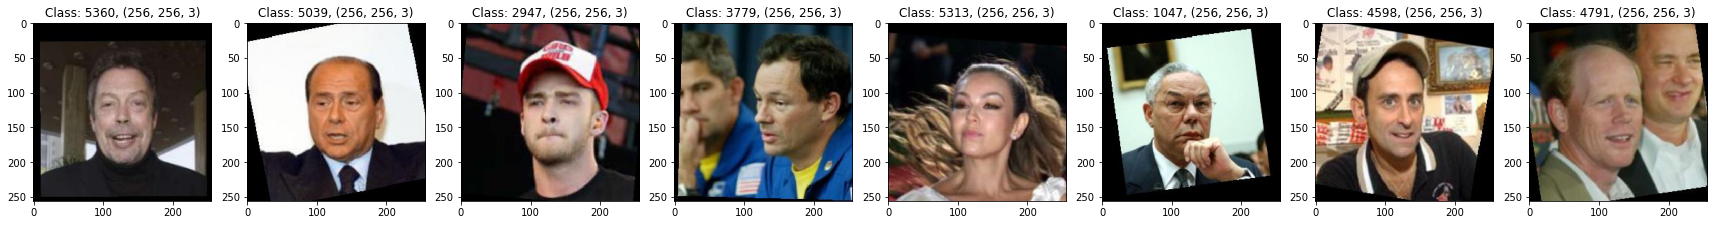

In [ ]:
show_first_images(image_generator, count=8)
# images of 256*256 * 3

##Построим нейросеть GAN   
генератора и дискриминатора

In [ ]:
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

In [ ]:
generator = M.Sequential([
    L.Dense(128*8*8, activation="relu"),
    L.Reshape((8, 8, 128)),
    L.UpSampling2D((2, 2)),    
    L.Conv2D(128, (3, 3), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.ReLU(),    
    L.UpSampling2D((2, 2)),    
    L.Conv2D(64, (3, 3), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.ReLU(),    
    L.UpSampling2D((2, 2)),    
    L.Conv2D(32, (3, 3), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.ReLU(),    
    L.UpSampling2D((2, 2)),    
    L.Conv2D(16, (3, 3), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.ReLU(),    
    L.UpSampling2D((2, 2)),    
    L.Conv2D(8, (3, 3), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.ReLU(),    
    L.Conv2D(3, (3, 3), padding="same", activation='tanh'),
])

discriminator = M.Sequential([
    L.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
    L.LeakyReLU(0.2),
    L.Dropout(0.25),    
    L.Conv2D(64, kernel_size=3, strides=(2, 2), padding="same"),
    L.ZeroPadding2D(padding=((0, 1), (0, 1))),
    L.BatchNormalization(momentum=0.8),
    L.LeakyReLU(alpha=0.2),
    L.Dropout(0.25),
    L.Conv2D(128, kernel_size=3, strides=(2, 2), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.LeakyReLU(alpha=0.2),
    L.Dropout(0.25),
    L.Conv2D(256, kernel_size=3, strides=(1, 1), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.LeakyReLU(alpha=0.2),
    L.Dropout(0.25),
    L.Flatten(),
    L.Dense(1, activation=None),
])



## Запустим обучение

In [ ]:
def plot_images(images, normalized=False):

    fig = plt.figure(figsize=(10, 10))
    num = images.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow(images[j, ...].reshape(256, 256, 3))
        plt.xticks([]), plt.yticks([])

    if not normalized:
      images = images.astype(np.unit8)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Step  0] D Loss: 0.0000; G Loss: 20.6403


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


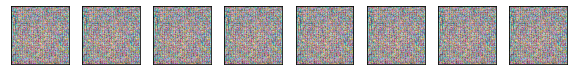

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Step 100] D Loss: 0.0000; G Loss: 22.2670


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


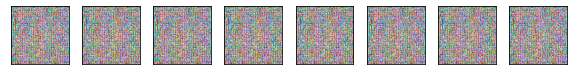

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Step 200] D Loss: 0.0000; G Loss: 21.9731


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


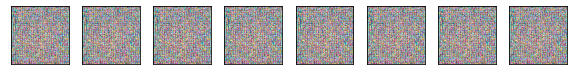

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Step 300] D Loss: 0.0000; G Loss: 22.3840


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


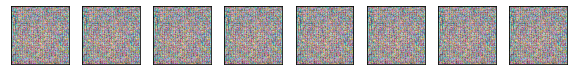

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Step 400] D Loss: 0.0000; G Loss: 22.5141


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


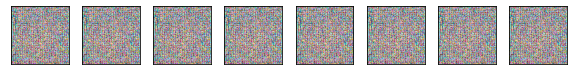

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Step 500] D Loss: 0.0000; G Loss: 22.8746


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


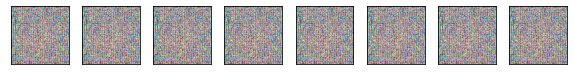

ValueError: ignored

In [ ]:
for step, true_images in enumerate(image_generator):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images[0], 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1)), 
        np.zeros((HALF_BATCH_SIZE, 1))))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = tf.compat.v1.losses.sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1))
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = tf.compat.v1.losses.sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 100 == 0:
        print("[Step %2d] D Loss: %.4f; G Loss: %.4f" % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_images(syntetic_images, normalized=True)
        #show_first_images(syntetic_images)
